# Modeling

We're going to try a few different tactics to see what gets us the best results.


1. Models based on the full feature set with PCA (for dimensionality reduction)
1. Models based on the full feature set without PCA (for dimensionality reduction)

1. Models based on a restricted set of features with and without PCA.


## Importing modules and data

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.decomposition import PCA


%matplotlib inline
sns.set_style('darkgrid')

In [12]:
np.random.seed(32)

In [13]:
df = pd.read_csv('../data/train_weather_spray_merged.csv')

In [14]:
df_dummied = pd.get_dummies(df, columns=['species'])

## Creating Validation Set, Scaling

In [15]:
df_dummied.drop(columns=['date', 'address', 'block', 'street', 'trap', 'addressnumberandstreet', 'nummosquitos', 'sunrise', 'sunset'], axis=1, inplace=True)

In [16]:
features = [col for col in df_dummied if col != 'wnvpresent']

In [17]:
df_dummied.columns

Index(['latitude', 'longitude', 'addressaccuracy', 'wnvpresent',
       'spray_nearby', 'station', 'tmax', 'tmin', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'tsra', 'sn', 'br', 'vcfg',
       'bcfg', 'hz', 'ra', 'dz', 'gr', 'mifg', 'sq', 'fg', 'ts', 'fg+', 'vcts',
       'fu', 'species_CULEX OTHER', 'species_CULEX PIPIENS',
       'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS'],
      dtype='object')

In [18]:
X = df_dummied[features]
y = df_dummied.wnvpresent

In [19]:
X.columns

Index(['latitude', 'longitude', 'addressaccuracy', 'spray_nearby', 'station',
       'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tsra', 'sn', 'br', 'vcfg', 'bcfg', 'hz', 'ra', 'dz', 'gr',
       'mifg', 'sq', 'fg', 'ts', 'fg+', 'vcts', 'fu', 'species_CULEX OTHER',
       'species_CULEX PIPIENS', 'species_CULEX PIPIENS/RESTUANS',
       'species_CULEX RESTUANS'],
      dtype='object')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)

In [21]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [22]:
with open('../models/scaler.pkl', 'wb') as file:
    pickle.dump(ss, file)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [24]:
pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [25]:
with open('../models/pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

## Logistic Regression w/out PCA 

In [45]:
logreg = LogisticRegression()
np.random.seed(41)
params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(1, 10, 3),
    'class_weight':['balanced']
}
gs_logreg = GridSearchCV(logreg, param_grid=params , scoring='roc_auc', verbose=1, return_train_score=True)

In [46]:
%%time
gs_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: user 1min 4s, sys: 517 ms, total: 1min 5s
Wall time: 1min 11s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 1. ,  5.5, 10. ]), 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [47]:
gs_logreg.best_params_

{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2'}

In [48]:
gs_logreg.score(X_train, y_train), gs_logreg.score(X_test, y_test)

(0.7535689801385388, 0.7442577689841573)

In [49]:
session_results = {
    'l1':{'train':[],'test':[]},
    'l2':{'train':[],'test':[]},
}
m_test_s = gs_logreg.cv_results_['mean_test_score']
m_train_s = gs_logreg.cv_results_['mean_train_score']

for index, session in enumerate(gs_logreg.cv_results_['params']):
    penalty = session['penalty']
    session_results[penalty]['train'].append(m_train_s[index])
    session_results[penalty]['test'].append(m_test_s[index])

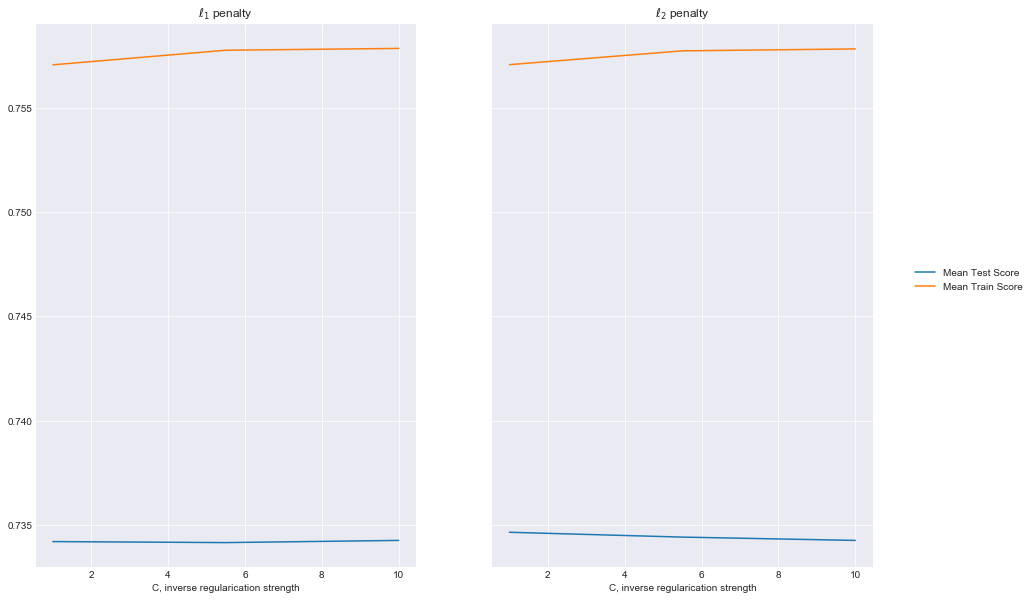

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10), sharey=True)

mtest_l1, mtrain_l1 = session_results['l1']['test'], session_results['l1']['train']
ax[0].plot(params['C'], mtest_l1, label='Mean Test Score')
ax[0].plot(params['C'], mtrain_l1, label='Mean Train Score')
ax[0].set_title('$\ell_1$ penalty')
ax[0].set_xlabel('C, inverse regularication strength')

mtest_l2, mtrain_l2 = session_results['l2']['test'], session_results['l2']['train']
ax[1].plot(params['C'], mtest_l2, label='Mean Test Score')
ax[1].plot(params['C'], mtrain_l2, label='Mean Train Score')
ax[1].set_title('$\ell_2$ penalty')
ax[1].set_xlabel('C, inverse regularication strength')
ax[1].legend(loc=(1.1,.5))




In [52]:
model_file = 'log_reg.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_logreg, file)

## Logistic Regression w/PCA on full set of features

In [55]:
lr = LogisticRegression()

params = {
    'penalty':['l1', 'l2'],
    'C':np.logspace(start=-5, stop=-1, num=2),
    'class_weight':['balanced'],
}
gs_lr_pca = GridSearchCV(lr, param_grid=params, return_train_score=True, scoring='roc_auc')
gs_lr_pca.fit(X_train_pca, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.e-05, 1.e-01]), 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [57]:
session_results = {
    'l1':{'train':[],'test':[]},
    'l2':{'train':[],'test':[]},
}
m_test_s = gs_lr_pca.cv_results_['mean_test_score']
m_train_s = gs_lr_pca.cv_results_['mean_train_score']

for index, session in enumerate(gs_lr_pca.cv_results_['params']):
    penalty = session['penalty']
    session_results[penalty]['train'].append(m_train_s[index])
    session_results[penalty]['test'].append(m_test_s[index])

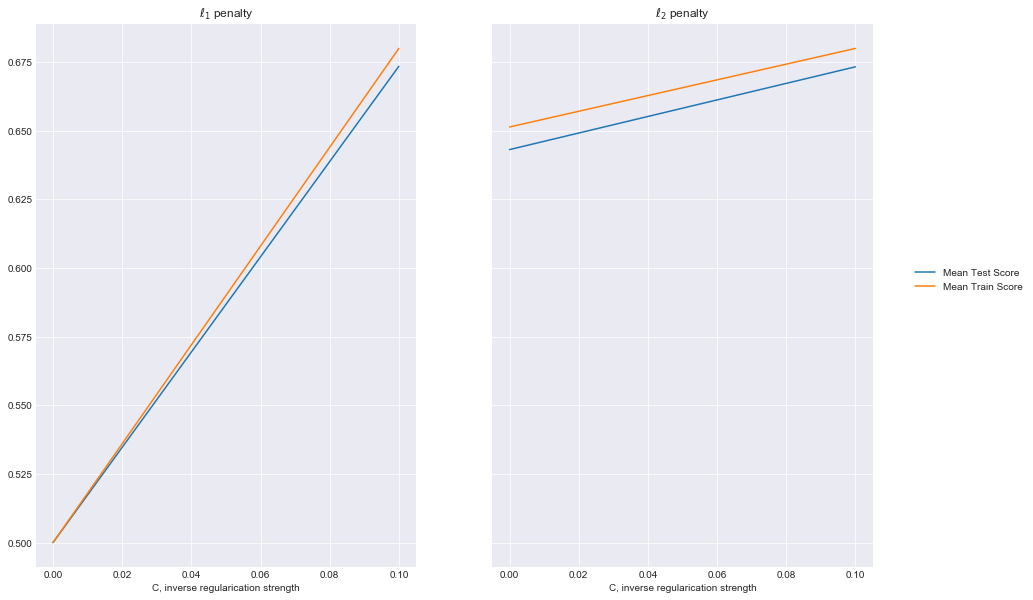

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10), sharey=True)

mtest_l1, mtrain_l1 = session_results['l1']['test'], session_results['l1']['train']
ax[0].plot(params['C'], mtest_l1, label='Mean Test Score')
ax[0].plot(params['C'], mtrain_l1, label='Mean Train Score')
ax[0].set_title('$\ell_1$ penalty')
ax[0].set_xlabel('C, inverse regularication strength')

mtest_l2, mtrain_l2 = session_results['l2']['test'], session_results['l2']['train']
ax[1].plot(params['C'], mtest_l2, label='Mean Test Score')
ax[1].plot(params['C'], mtrain_l2, label='Mean Train Score')
ax[1].set_title('$\ell_2$ penalty')
ax[1].set_xlabel('C, inverse regularication strength')
ax[1].legend(loc=(1.1,.5))




In [61]:
gs_lr_pca.score(X_train_pca, y_train), gs_lr_pca.score(X_test_pca, y_test)

(0.6793662257411722, 0.6918598223827247)

In [62]:
gs_lr_pca.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}

In [63]:
model_file = 'log_reg_pca.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_lr_pca, file)

Similar results with $\ell_1$ and $\ell_2$ regularization, with a slight advantage to $\ell_1$. Not much evidence of overfitting in comparing the training and test scores.

## Decision Tree with full feature space.

In [68]:
params = {
    'min_samples_split' : [2, 3, 4, 5],
    'min_samples_leaf': [2],
}

gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc')

In [69]:
gs_dt.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [70]:
gs_dt.score(X_train, y_train), gs_dt.score(X_test, y_test)

(0.9823324337819203, 0.693464217177229)

In [81]:
pd.Series(gs_dt.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

latitude                          0.276744
longitude                         0.221640
species_CULEX PIPIENS/RESTUANS    0.061891
species_CULEX PIPIENS             0.053411
resultdir                         0.053225
tmax                              0.038201
species_CULEX RESTUANS            0.037736
addressaccuracy                   0.037183
resultspeed                       0.032450
tmin                              0.029019
dtype: float64

In [83]:
model_file = 'dt.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_dt, file)

## Random Forest with full feature space

In [84]:
params = {
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2],
    'class_weight': ['balanced'],
}

gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='roc_auc')

In [85]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [86]:
gs_rf.score(X_train, y_train), gs_rf.score(X_test, y_test)

(0.9759994135083299, 0.8209427378458591)

In [90]:
pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

longitude          0.153522
latitude           0.144181
cool               0.062030
resultspeed        0.053561
tmax               0.052548
avgspeed           0.050539
addressaccuracy    0.048638
tavg               0.043653
wetbulb            0.043020
sealevel           0.037061
dtype: float64

In [91]:
gs_rf.best_params_

{'class_weight': 'balanced', 'min_samples_leaf': 2, 'min_samples_split': 3}

## AdaBoost w/Logistic Regression base and PCA

In [92]:
np.random.seed(41)
ada = AdaBoostClassifier()
params = {
        'base_estimator':[LogisticRegression(class_weight='balanced')],
        'n_estimators': [10],
}
gs_ada = GridSearchCV(ada, param_grid=params, scoring='roc_auc', verbose=1, return_train_score=True,)

%time gs_ada.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 998 ms, sys: 27.6 ms, total: 1.03 s
Wall time: 530 ms


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator': [LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)], 'n_estimators': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

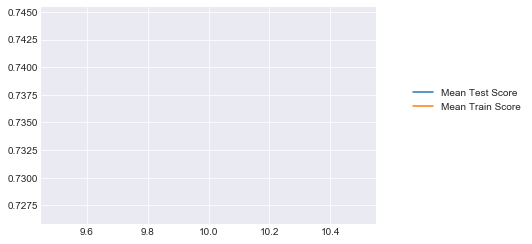

In [93]:
mtest, mtrain = gs_ada.cv_results_['mean_test_score'], gs_ada.cv_results_['mean_train_score']
plt.plot(params['n_estimators'], mtest, label='Mean Test Score')
plt.plot(params['n_estimators'], mtrain, label='Mean Train Score')
plt.legend(loc=(1.1, .5))


In [94]:
gs_ada.best_params_

{'base_estimator': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'n_estimators': 10}

In [95]:
gs_ada.score(X_train, y_train), gs_ada.score(X_test, y_test)

(0.7412440690369384, 0.7394162384028617)

In [103]:
model_file = 'ada.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_ada, file)

## Bagging

In [105]:
np.random.seed(41)

bag = BaggingClassifier()
params = {
    'n_estimators': range(1,201, 100),
}
gs_bag = GridSearchCV(bag, param_grid = params, scoring='roc_auc', verbose=1, return_train_score=True)
%time gs_bag.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.3s finished


CPU times: user 7.36 s, sys: 253 ms, total: 7.61 s
Wall time: 7.66 s


GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(1, 201, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

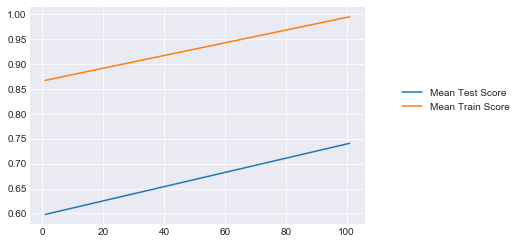

In [106]:
mtest, mtrain = gs_bag.cv_results_['mean_test_score'], gs_bag.cv_results_['mean_train_score']
plt.plot(params['n_estimators'], mtest, label='Mean Test Score')
plt.plot(params['n_estimators'], mtrain, label='Mean Train Score')
plt.legend(loc=(1.1, .5))


In [107]:
gs_bag.best_params_

{'n_estimators': 101}

In [108]:
gs_bag.score(X_train, y_train), gs_bag.score(X_test, y_test)

(0.9925352753604809, 0.7819369523868916)

In [109]:
model_file = 'bag.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_bag, file)

There is a huge gulf between the testing and training scores for the bagged trees, this model is highly overfit.

## KNN

In [111]:
knn = KNeighborsClassifier()
params = {
    'n_neighbors': range(2,3),  
    'weights':['uniform']
}
gs_knn = GridSearchCV(knn, param_grid = params, scoring='roc_auc', verbose=1, return_train_score=True)
gs_knn.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(2, 3), 'weights': ['uniform']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

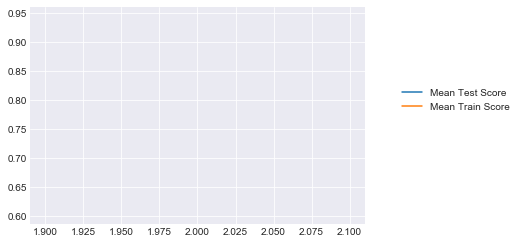

In [112]:
mtest, mtrain = gs_knn.cv_results_['mean_test_score'], gs_knn.cv_results_['mean_train_score']
plt.plot(params['n_neighbors'], mtest, label='Mean Test Score')
plt.plot(params['n_neighbors'], mtrain, label='Mean Train Score')
plt.legend(loc=(1.1, .5))


In [113]:
gs_knn.best_params_

{'n_neighbors': 2, 'weights': 'uniform'}

In [114]:
gs_knn.score(X_train, y_train), gs_knn.score(X_test, y_test)

(0.9286961854264745, 0.6199029993111873)

In [115]:
model_file = 'knn.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_knn, file)

Very bizarre behavior in the training and testing scores, test score is increasing for (approximately) k between 1 and 25, then decreasing while training scores is strictly decreasing. 

## Restricting the Feature Space

In [116]:
limited_cols = ['latitude', 'longitude', 'tmax', 'species', 'wnvpresent']
lim_features = [col for col in df[limited_cols] if col != 'wnvpresent']
X_limited = pd.get_dummies(df[lim_features])
X_limited.drop(columns=['species_CULEX OTHER','species_CULEX PIPIENS/RESTUANS','species_CULEX RESTUANS'], inplace=True)
y_limited = df[limited_cols]['wnvpresent']

In [117]:
X_trl, X_tsl, y_trl, y_tsl = train_test_split(X_limited, y_limited)

In [119]:
X_limited.columns

Index(['latitude', 'longitude', 'tmax', 'species_CULEX PIPIENS'], dtype='object')

In [120]:
ss_limited = StandardScaler()
X_trl = ss_limited.fit_transform(X_trl)
X_tsl = ss_limited.transform(X_tsl)


## PCA on restricted features

In [122]:
pca = PCA(n_components=4)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


## Decision Tree

In [126]:
params = {
    'min_samples_split' : [2, 3, 4],
#     'min_samples_leaf': [2, 3, 4],
#     'max_depth': range(5, 25),
#     'class_weight' : ['balanced'],
#     'max_features': ['auto', None],
    'random_state': [32],
}

gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc')

In [127]:
gs_dt.fit(X_trl, y_trl)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'random_state': [32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [128]:
gs_dt.score(X_trl, y_trl), gs_dt.score(X_tsl, y_tsl)

(0.9644035551515163, 0.6093117408906883)

In [129]:
gs_dt.best_params_

{'min_samples_split': 4, 'random_state': 32}

## Random Forests

In [131]:
params = {
    'min_samples_split': [3],
    'min_samples_leaf': range(5, 11, 1),
    'class_weight': ['balanced'],
    'n_estimators': [1000],
}

gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='roc_auc', verbose=1)

In [132]:
gs_rf.fit(X_trl, y_trl)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [3], 'min_samples_leaf': range(5, 11), 'class_weight': ['balanced'], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [133]:
gs_rf.score(X_trl, y_trl), gs_rf.score(X_tsl, y_tsl)

(0.9211456151415006, 0.6976951995373047)

In [134]:
gs_dt.best_params_

{'min_samples_split': 4, 'random_state': 32}

## Summary

The vanilla Logistic Regression with $\ell_1$ regularization is the best of these models. It shows little evidence of overfit, is very fast, small and we will use the learned parameters later to infer importances of the the combined features resulting from PCA. 